<a href="https://colab.research.google.com/github/dmtrung14/pyTorch_fundamentals/blob/main/PyTorch_Fundamentals_Classification_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch in Machine Learning Classification

Types of classification problems: 
* Binary classification: Spam filtering
* Multiclass: food identifier
* Multilabel classification: what tags should this wikipedia have?

Let's not mistaken *Multiclass* vs *multilabel* classification, the first one define which class among the labels should this object be classified as, and the later one which (multiple labels) should be applied. 

As we'll see, we will use `softmax` for the first one, and other algos for the latter


## Make classificaion data and get it ready

In [3]:
import sklearn

In [4]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

x,y = make_circles(n_samples, noise = 0.03, random_state= 42)

len(x), len(y), x[:5], y[:5]

(1000,
 1000,
 array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
from IPython.lib.display import YouTubeVideo
# Make DataFram of circle data
import pandas as pd
circles = pd.DataFrame({"X1": x[:,0], 
                        "X2": x[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


### Check input and output shapes


In [6]:
x.shape,y.shape

((1000, 2), (1000,))

### Turn data into tensors and create train and test splits

In [7]:
import torch

In [8]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
#split data into training and test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state = 42)
len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

Let's build a model to classify our points into 2 circles. 
To do so, we want to:
1. set up device agnostic code so our code will run on an acceleartor (GPU) if there is one.
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and an optimizer
4. Create a training and test loop


In [10]:
import torch
from torch import nn

## Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclass ``nn.module`` (almost all models in PyTOrch subclass this module)
2. Create 2 `nn.Linear` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass for forward computation of the model
4. Instantiate an instance of our model class and send it to the target device.


In [11]:
# Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features =5) #Takes in 2 features and output 5 features
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1) #Takes in 5 features and output 1 result
  
  #Define a forward() method that outlines the forward pass
  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.layer_2(self.layer_1(x)) #x -> layer 1 -> layer 2 -> output

# Instantiate an instance of our model class and send it to the target device

model_0 = CircleModelV0().to(device)
list(model_0.parameters())


[Parameter containing:
 tensor([[-0.1101, -0.4416],
         [ 0.6462,  0.6990],
         [ 0.1809,  0.3797],
         [ 0.3975,  0.4081],
         [-0.6058, -0.0981]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.3670,  0.1518,  0.4053, -0.0398, -0.0894], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[0.2513, 0.3742, 0.4359, 0.4187, 0.0995]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.0177], device='cuda:0', requires_grad=True)]

In [12]:
device

'cuda'

##``nn.Sequential`` to replicate the model in an easier ưay



In [13]:
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0, model_0.state_dict()

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('0.weight',
               tensor([[-0.5537,  0.7000],
                       [ 0.5313, -0.0211],
                       [-0.6352,  0.0953],
                       [ 0.7066, -0.3029],
                       [ 0.1972,  0.0828]], device='cuda:0')),
              ('0.bias',
               tensor([ 0.5075,  0.0356,  0.2701, -0.2963, -0.3106], device='cuda:0')),
              ('1.weight',
               tensor([[-0.4108,  0.0988, -0.4240,  0.2894,  0.1481]], device='cuda:0')),
              ('1.bias', tensor([0.0513], device='cuda:0'))]))

In [14]:
#Let's make some prediction with our new model:
untrained_preds = model_0(x_test.to(device))
x_test[:10], untrained_preds[:10], torch.round(untrained_preds[:10])

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([[-0.9705],
         [-0.7771],
         [-0.8226],
         [-1.0151],
         [ 0.2167],
         [ 0.3267],
         [ 0.0474],
         [ 0.3085],
         [-0.8666],
         [-0.7527]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[-1.],
         [-1.],
         [-1.],
         [-1.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [-1.],
         [-1.]], device='cuda:0', grad_fn=<RoundBackward0>))

### Set up loss function and optimizer
Which loss function or optimizer should you use?

For example, for regression you might want MAE or MSE

For classification you might want binary cross entropy or categorical cross entropy

* For the loss function we are going to use ``torch.nn.BCEWithLogitsLoss()``.

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [16]:
#Calculate accuracy - out of 100 example, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## 3. Train our Model

To train our model, we need to build a training loop, which includes:

1. Forward pass
2. Calculate the loss
3. Optimizer zero gra
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outpus are going to be raw logits


We can convert these logits into prediction probabilityies by passing them to some kind of activation function (e.g. sigmoid for binary classification and softwmax for mutlticlass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [17]:
#view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_test.to(device))[:5]
y_logits

tensor([[-0.9705],
        [-0.7771],
        [-0.8226],
        [-1.0151],
        [ 0.2167]], device='cuda:0')

In [18]:
# Use the sigmoid activation function on our model logits to turn them into prediction
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs, torch.round(y_pred_probs)

(tensor([[0.2748],
         [0.3149],
         [0.3052],
         [0.2660],
         [0.5540]], device='cuda:0'),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.]], device='cuda:0'))

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y =1`, (class 1)
* `y_pred_probs` < 0.5, `y = 0`, (class 0)


In [19]:
#Find the predicted labels
y_preds = torch.round(y_pred_probs)

#In full
y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))[:5]))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop of our own


In [21]:
epochs = 1000
torch.cuda.manual_seed(42)
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)
for epoch in range(epochs):
  model_0.train()

  #Make the forward pass
  y_logits = model_0(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  #calculate the loss / accuracy
  loss = loss_fn(y_logits, 
                 y_train) # nn.BCEWithLoss expects raw logits as inputs,
                          # nn.BCELoss expects prediction probability as input
  acc = accuracy_fn(y_train, y_pred) 
  
  #zero grad to clear accumulating 
  optimizer.zero_grad()

  #backpropagation
  loss.backward()

  #optimizer step (gradient descent step)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    #1. forward pass
    test_logits = model_0(x_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    #2. calculate the test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_test, test_preds)
  
  #Print out what's happening

  if epoch%50 == 0:
    print(f'{epoch} | Loss {loss:.5f} | Acc: { acc:.2f} | Test loss: {test_loss: .5f} | Test acc: {test_acc: .2f}%')


  

0 | Loss 0.75118 | Acc: 48.50 | Test loss:  0.74485 | Test acc:  45.50%
50 | Loss 0.69746 | Acc: 49.50 | Test loss:  0.69722 | Test acc:  52.00%
100 | Loss 0.69420 | Acc: 50.12 | Test loss:  0.69458 | Test acc:  53.50%
150 | Loss 0.69338 | Acc: 51.12 | Test loss:  0.69401 | Test acc:  49.50%
200 | Loss 0.69313 | Acc: 51.25 | Test loss:  0.69392 | Test acc:  50.50%
250 | Loss 0.69304 | Acc: 51.50 | Test loss:  0.69397 | Test acc:  47.50%
300 | Loss 0.69301 | Acc: 51.75 | Test loss:  0.69405 | Test acc:  46.00%
350 | Loss 0.69300 | Acc: 51.50 | Test loss:  0.69413 | Test acc:  45.50%
400 | Loss 0.69299 | Acc: 51.38 | Test loss:  0.69421 | Test acc:  46.00%
450 | Loss 0.69299 | Acc: 51.38 | Test loss:  0.69428 | Test acc:  45.50%
500 | Loss 0.69299 | Acc: 51.50 | Test loss:  0.69434 | Test acc:  45.50%
550 | Loss 0.69298 | Acc: 51.38 | Test loss:  0.69439 | Test acc:  46.00%
600 | Loss 0.69298 | Acc: 51.25 | Test loss:  0.69443 | Test acc:  45.50%
650 | Loss 0.69298 | Acc: 51.25 | Test lo

## 4. Make predictions an devaluate the model

From the metrics it looks like our model isn't learning anything

So to inspect it let's make some predictions and make the visual!

To do so we are going to import a function called `plot_decision_boundary`

Please refer to the lectures for more information: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py



In [22]:
import requests
from pathlib import Path
# Download helper functions from Learn PyTorch repo

if Path("helper_functions.py").is_file():
  print("already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary



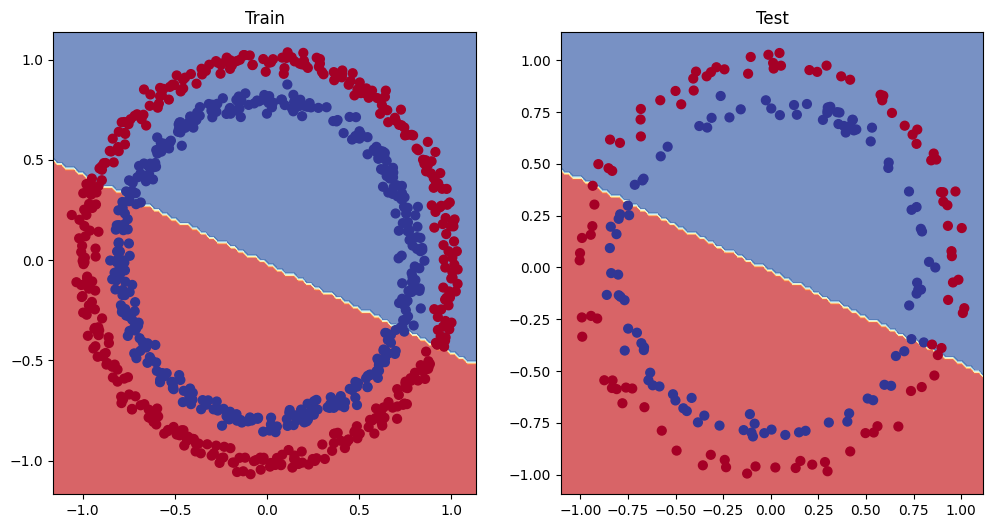

In [23]:
# Plot decision boundary of the model
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

## 5. Improving our model (from a model perspective)

Common ways to revise and improve a model:

* add more layers -give the model more chances to learn about patterns in the data (more depths in term of the number of layers)
* add more hidden units - go from 5 to 10 units in the second layer for example (more depth in each layer) 
* fit for longer (more epochs)
* changing the activation functions
* change the learning rate (lr)
* change the loss functions

These options are all from a model's perspective because they deal directly from the data.

And because these options are all values we (as machine learning and data scientists) can change, they are referred to as **hyper-parameters**. 

So let's try to change some hyperparamters of our model

In [24]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
  def forward(self, x: torch.tensor):
    return self.layer_3(self.layer_2(self.layer_1(x))) # x -> layer 1 -> layer 2 -> layer 3
model_1 = CircleModelV1().to(device)
model_1, device



(CircleModelV1(
   (layer_1): Linear(in_features=2, out_features=10, bias=True)
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): Linear(in_features=10, out_features=1, bias=True)
 ),
 'cuda')

In [25]:
# Create a loss function

loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)


Create the learning and testing loop

In [26]:
# write a training and testing evaluation loop for model_1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

#Put the data on to the target device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Set model to train mode
  model_1.train()

  # Forward propagation
  y_logits = model_1(x_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) #logits -> pred probabilities -> labels

  #calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # zero_grad

  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # opimizer gradient descent
  optimizer.step()

  with torch.inference_mode():
    #1. forward pass:
    test_logits = model_1(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. calculate the loss:
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
  if epoch %100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc: .2f} | Test loss: {test_loss} | Test accuracy: {test_acc}')


Epoch: 0 | Loss:  0.69681 | Acc:  51.12 | Test loss: 0.6960346102714539 | Test accuracy: 50.0
Epoch: 100 | Loss:  0.69463 | Acc:  51.12 | Test loss: 0.6940412521362305 | Test accuracy: 50.0
Epoch: 200 | Loss:  0.69376 | Acc:  51.12 | Test loss: 0.6933401226997375 | Test accuracy: 50.0
Epoch: 300 | Loss:  0.69341 | Acc:  51.12 | Test loss: 0.6931319236755371 | Test accuracy: 50.0
Epoch: 400 | Loss:  0.69326 | Acc:  51.12 | Test loss: 0.6931084990501404 | Test accuracy: 50.0
Epoch: 500 | Loss:  0.69319 | Acc:  51.12 | Test loss: 0.6931518316268921 | Test accuracy: 50.0
Epoch: 600 | Loss:  0.69315 | Acc:  51.12 | Test loss: 0.6932169198989868 | Test accuracy: 44.5
Epoch: 700 | Loss:  0.69312 | Acc:  51.12 | Test loss: 0.693287193775177 | Test accuracy: 46.0
Epoch: 800 | Loss:  0.69310 | Acc:  51.12 | Test loss: 0.6933566331863403 | Test accuracy: 48.0
Epoch: 900 | Loss:  0.69309 | Acc:  51.12 | Test loss: 0.6934232711791992 | Test accuracy: 46.5


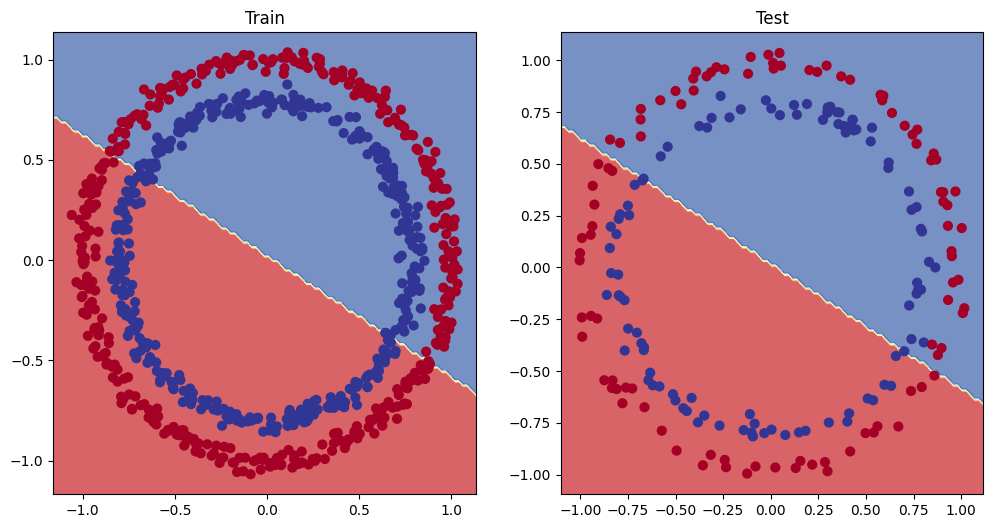

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, x_test, y_test)

## 6. Non-linearity in activation functions

*What pattern scould you draw if you were given an infinte amout of straight lights*


Or in machine learning terms, an infinte of linear and non-linear functions

### 6.1 Recreating non-linear data (red and blue circles)

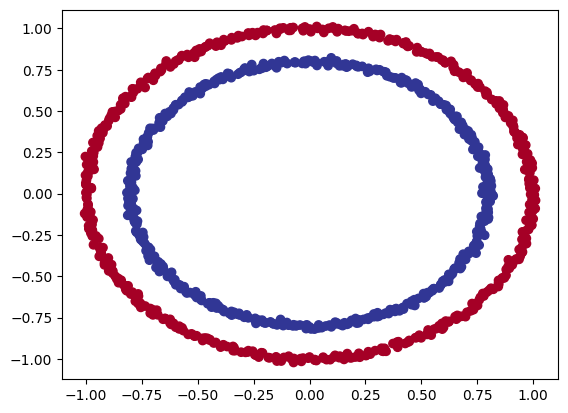

In [28]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples
x,y = make_circles(n_samples,
                   noise = 0.01,
                   random_state = 42)
plt.scatter(x[:, 0], x[:, 1], c= y, cmap = plt.cm.RdYlBu);

In [29]:
# Convert data to tensors and then to train and test splits

import torch
from sklearn.model_selection import train_test_split

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train and tet sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)
x_train[:5], y_train[:5]

(tensor([[ 0.6387, -0.4846],
         [ 0.6609, -0.7366],
         [-0.9953, -0.1415],
         [-0.9719, -0.2247],
         [-0.1686,  0.7877]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

*Let's add some curve to our model 😸*


In [30]:
## Building a non-linear model
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [31]:
## Set up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), 
                            lr = 0.1)

In [32]:
y_train.shape

torch.Size([800])

In [33]:
## Training our model with non-linearity
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put all data in to the same device
x_train, y_train, x_test, y_test = x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)

#set epochs
epochs = 1000
for epoch in range(epochs):
  model_3.train()

  #1.forward pass
  y_logits = model_3(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  #3. zero_grad
  optimizer.zero_grad()

  #4. backpropagation
  loss.backward()

  #5. optimizer gradient descent
  optimizer.step()

  ###Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits =model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_pred, y_test)
  
  if epoch %100 == 0:
    print(f'Epoch: {epoch} | Acc: {acc:.2f}% | Loss: {loss:.5f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%')


Epoch: 0 | Acc: 50.00% | Loss: 0.69295 | Test Loss: 0.69307 | Test Acc: 50.00%
Epoch: 100 | Acc: 53.12% | Loss: 0.69117 | Test Loss: 0.69081 | Test Acc: 53.00%
Epoch: 200 | Acc: 52.88% | Loss: 0.68983 | Test Loss: 0.68907 | Test Acc: 55.50%
Epoch: 300 | Acc: 53.00% | Loss: 0.68803 | Test Loss: 0.68674 | Test Acc: 56.50%
Epoch: 400 | Acc: 53.12% | Loss: 0.68521 | Test Loss: 0.68336 | Test Acc: 56.50%
Epoch: 500 | Acc: 53.00% | Loss: 0.68117 | Test Loss: 0.67822 | Test Acc: 56.50%
Epoch: 600 | Acc: 53.62% | Loss: 0.67532 | Test Loss: 0.67110 | Test Acc: 57.50%
Epoch: 700 | Acc: 57.63% | Loss: 0.66659 | Test Loss: 0.66043 | Test Acc: 61.00%
Epoch: 800 | Acc: 63.88% | Loss: 0.65164 | Test Loss: 0.64386 | Test Acc: 69.50%
Epoch: 900 | Acc: 74.12% | Loss: 0.62356 | Test Loss: 0.61609 | Test Acc: 78.00%


In [34]:
## Evaluating a model trained with non-lienar activation functions

model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(x_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

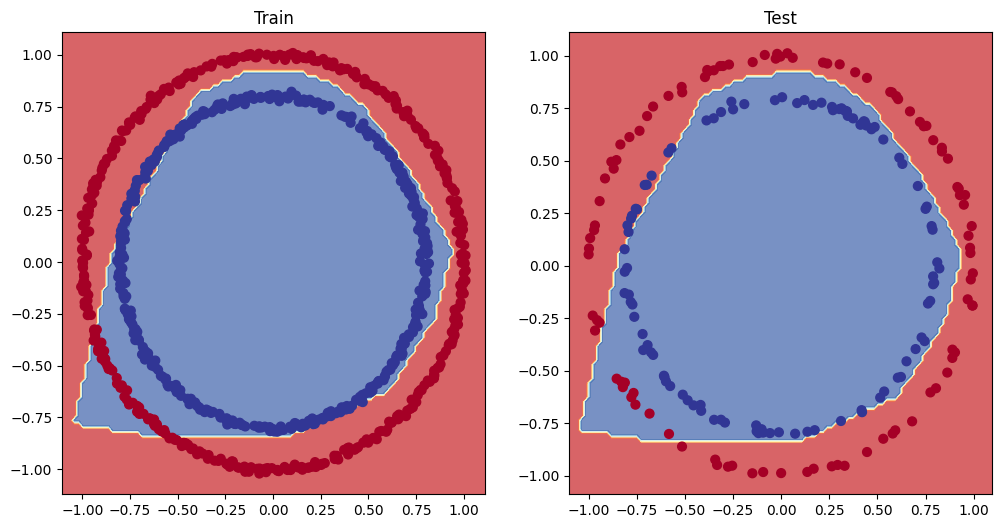

In [35]:
#Plot decision boundaries
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, x_test, y_test)

## 7. Replicating non-linear activation function

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in the data and it tries to figure out the pattern on its own.

And these tools are linear and non-linear functions.

Text(0.5, 1.0, 'Rectified Linear Unit')

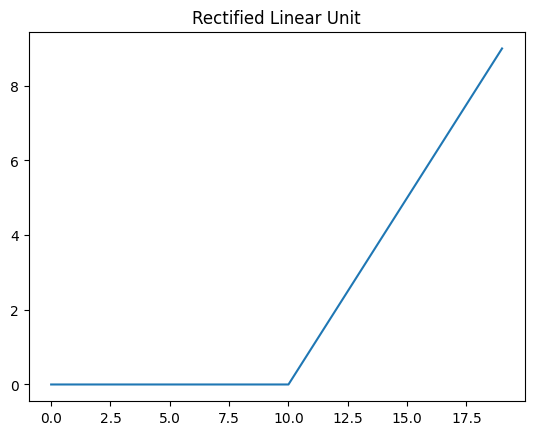

In [36]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A.dtype
plt.plot(torch.relu(A))
plt.title("Rectified Linear Unit")

Text(0.5, 1.0, 'Sigmoid function')

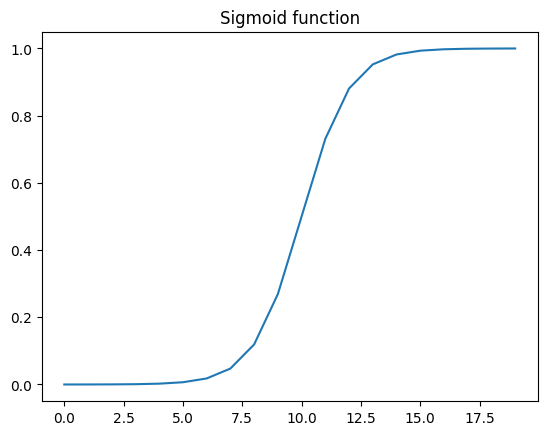

In [37]:
# Now let's do the same for sigmoid
plt.plot(torch.sigmoid(A))
plt.title("Sigmoid function")

## 8. Putting it all together with a multi-class classification problem

* Binary classfication = one thing or another (cat vs dog, fraud vs not fraud, spam vs not spam)
*Multi-class classfication = more than one thing or another (cat vs dog vs duck, types of grades A, B, C, D, F)

###8.1 Creating a toy multi-lcass dataset

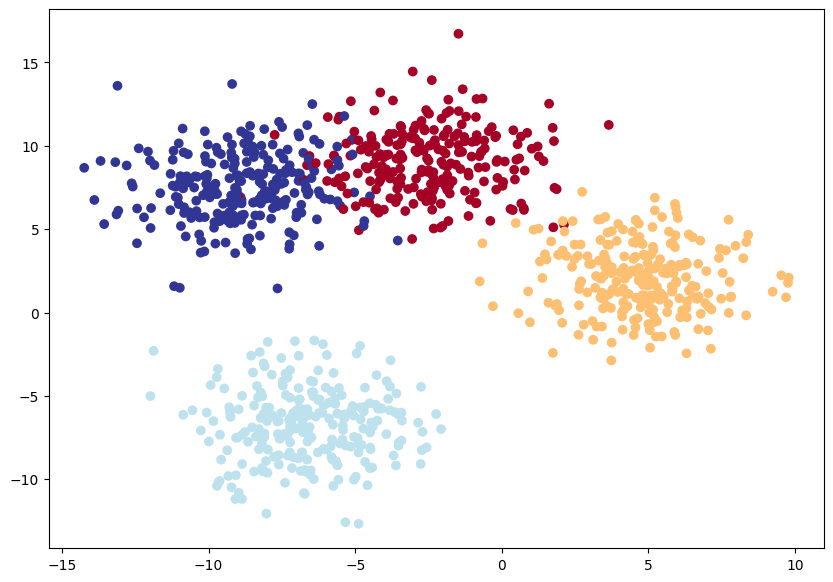

In [38]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(n_samples = 1000, n_features = NUM_FEATURES, 
                            centers = NUM_CLASSES, 
                            cluster_std = 2, 
                            random_state = RANDOM_SEED)

# Turn data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob, y_blob, train_size = 0.2, random_state = RANDOM_SEED)
# plot data
plt.figure(figsize = (10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)


###8.2 Building a multi-class classification model in PyTorch

In [39]:
## setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
## build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of the blob model and send to the device
model_4 = BlobModel(input_features = 2, output_features = 4, hidden_units = 8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [41]:
## Create a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr = 0.1) #lr is a hyperparameters though change it if you want



### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [42]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(x_blob_test.to(device))
y_logits[:10], y_blob_test[:10]

(tensor([[-0.8118, -0.8307, -1.6751, -1.1760],
         [-0.0902, -0.9269, -0.5813, -0.1338],
         [ 0.2456, -0.2423,  0.1883, -0.0032],
         [-0.3472, -0.4911, -0.8196, -0.6231],
         [-0.3540, -1.4595, -1.3139, -0.4283],
         [-0.1611, -1.0871, -0.7362, -0.1712],
         [ 0.0953, -0.3387,  0.0747, -0.0551],
         [-0.2159, -1.1802, -0.9321, -0.2757],
         [ 0.2352, -0.2664,  0.1415,  0.0078],
         [-0.2434, -1.2318, -1.0178, -0.3158]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

In order to evaluate and train and test our model, we need to convert from logits to prediction probabilities, using an activation. 

For binary classification, we use sigmoid function, but for multi-class classfication, we use the more advanced version of the sigmoid function, namely the softmax activation function

In [43]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])
torch.sum(y_pred_probs[0]), torch.argmax(y_pred_probs[0]) +1

tensor([[-0.8118, -0.8307, -1.6751, -1.1760],
        [-0.0902, -0.9269, -0.5813, -0.1338],
        [ 0.2456, -0.2423,  0.1883, -0.0032],
        [-0.3472, -0.4911, -0.8196, -0.6231],
        [-0.3540, -1.4595, -1.3139, -0.4283]], device='cuda:0')
tensor([[0.3228, 0.3168, 0.1361, 0.2243],
        [0.3331, 0.1443, 0.2038, 0.3188],
        [0.2996, 0.1839, 0.2829, 0.2336],
        [0.3078, 0.2666, 0.1919, 0.2336],
        [0.3785, 0.1253, 0.1449, 0.3514]], device='cuda:0')


(tensor(1., device='cuda:0'), tensor(1, device='cuda:0'))

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model


In [45]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10000

x_blob_train, y_blob_train, x_blob_test, y_blob_test = x_blob_train.to(device), y_blob_train.to(device), x_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  # train
  model_4.train()

  # forward propagation
  y_logits = model_4(x_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  # loss function
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)

  #zero grad
  optimizer.zero_grad()
  
  loss.backward()

  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(x_blob_test)
    test_pred = torch.softmax(test_logits, dim =1 ). argmax(dim =1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)
  
  if epoch %1000 == 0:
    print(f'Epoch: {epoch} | acc: {acc:.5f}% | loss: {loss} | test loss: {test_loss} | test acc: {test_acc}%')


Epoch: 0 | acc: 97.50000% | loss: 0.07483434677124023 | test loss: 0.1077171266078949 | test acc: 95.875%
Epoch: 1000 | acc: 97.50000% | loss: 0.05473608151078224 | test loss: 0.11863896250724792 | test acc: 96.125%
Epoch: 2000 | acc: 97.50000% | loss: 0.05117085948586464 | test loss: 0.12026030570268631 | test acc: 96.375%
Epoch: 3000 | acc: 98.50000% | loss: 0.04854900389909744 | test loss: 0.122800312936306 | test acc: 96.5%
Epoch: 4000 | acc: 98.00000% | loss: 0.04508691653609276 | test loss: 0.1288394331932068 | test acc: 96.5%
Epoch: 5000 | acc: 98.00000% | loss: 0.04037151858210564 | test loss: 0.14120259881019592 | test acc: 96.25%
Epoch: 6000 | acc: 98.50000% | loss: 0.03606286272406578 | test loss: 0.15920837223529816 | test acc: 95.875%
Epoch: 7000 | acc: 98.50000% | loss: 0.03292626142501831 | test loss: 0.17094102501869202 | test acc: 96.25%
Epoch: 8000 | acc: 99.00000% | loss: 0.03037787415087223 | test loss: 0.18020309507846832 | test acc: 96.375%
Epoch: 9000 | acc: 99.0

In [46]:
### 8.6 Making and evaluating predictions with a PyTorch multiclass model

model_4.eval()
with torch.inference_mode():
  y_logits = model_4(x_blob_test)

# view the first 10 predictions
y_logits[:10]

tensor([[-10.2205,  29.1239, -16.5728, -18.4889],
        [ -9.8173, -14.8715,  -4.7117,   8.7600],
        [-51.7591, -25.3416,  19.4449,   9.1562],
        [ -8.9080,  23.1616, -11.9559, -13.9573],
        [ 10.6459,   0.4314,  -9.0714, -10.1049],
        [-16.2808, -20.5201,  -5.0920,  12.8539],
        [-40.7789, -19.9718,  15.4771,   6.9286],
        [  8.0236,  -3.8501,  -7.0018,  -3.7410],
        [-71.2022, -34.8545,  26.3435,  13.0465],
        [  9.7750,  -2.7930,  -7.0013,  -6.5665]], device='cuda:0')

In [50]:
# Go from logits to prediction probability
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:10].argmax(dim =1), y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

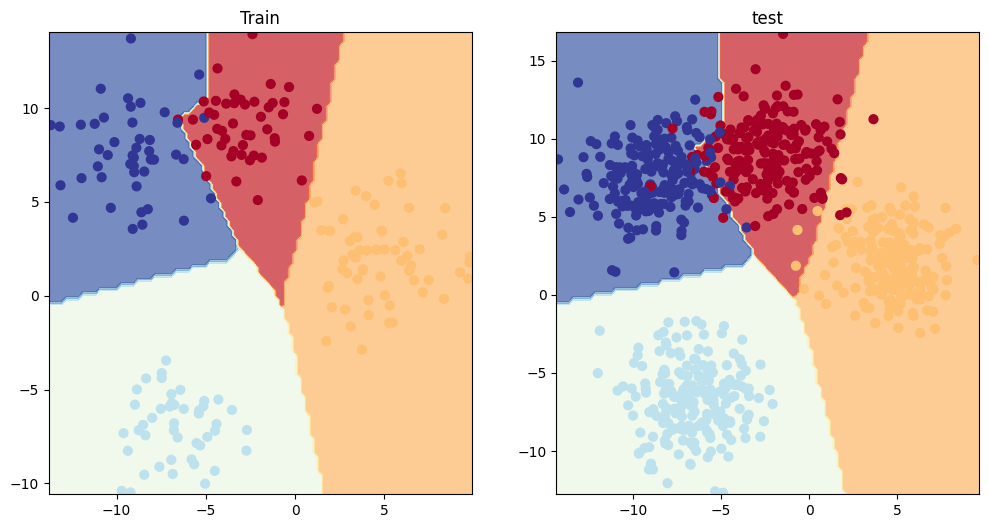

In [51]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, x_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test)


##9. A few moere classification metrics (to evaluate our classification model)

* Accuracy - out of 100 samples, how many samples do we get right. Refernce here: https://towardsdatascience.com/beyond-accuracy-other-classification-metrics-you-should-know-in-machine-learning-ea671be83bb7
* Precision - tp/(tp+fp)
* Recall - tp/(tp+fn)
* F1-score - precision*recall/(precision + recall)
* Confusion Matrix

If you want access to a lot of PyTorch metrics, access `TorchMetrics`



In [52]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.1 MB/s eta 0:00:00
